# 4. Mushroom foraging

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [50]:
import pandas as pd
import numpy as np
from nltk import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv', delimiter = ';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


It's up to you how you approach this data, but at a minimum, your analysis should include:

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.

## Dataforberedelse

### 1. Dataundersøgelse

Vi starter med at undersøge datasættets struktur og typer:

- **Form:** 61.069 rækker og 21 kolonner
- **Datatyper:** 3 numeriske features, 18 kategoriske features
- **Manglende værdier:** Flere kolonner indeholder NaN og kræver behandling


In [51]:
# Udskriv datatype og manglende værdier for hver kolonne
df.info()

# Udskriv unikke værdier i hver kolonne
for column in df.columns:
    print(f"{column}: {df[column].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

### 2. Håndtering af manglende værdier

**Kolonner med mange manglende værdier (fjernes):**

| Kolonne              | Ikke-NaN værdier |
|----------------------|------------------|
| `stem-root`          | 5931             |
| `veil-type`          | 3177             |
| `veil-color`         | 7413             |
| `spore-print-color`  | 6354             |

Disse kolonner fjernes helt, da de har for mange manglende værdier til at være meningsfulde i modellerne.
Kolonnen `has-ring` fjernes også, da informationen allerede er dækket af `ring-type`.

#### Kategoriske kolonner med få manglende værdier:
- `cap-surface`, `stem-surface`, `gill-spacing`, `gill-attachment`, `ring-type`

Da alle disse er kategoriske, vælger vi at udfylde de manglende værdier med en ny kategori `"missing"` for at bevare datastrukturen.
Vi tjekker til sidst, at der ikke er flere manglende værdier i datasættet.

In [52]:
# Fjern kolonner med mange manglende værdier samt 'has-ring'
df_reduced = df.drop(['stem-root', 'veil-type', 'veil-color', 'spore-print-color', 'has-ring'], axis=1)

# Udfyld manglende værdier med ny kategori "missing"
kategoriske_kolonner_med_nan = ['cap-surface', 'gill-attachment', 'stem-surface', 'gill-spacing', 'ring-type']
df_reduced[kategoriske_kolonner_med_nan] = df_reduced[kategoriske_kolonner_med_nan].fillna('missing')

# Tjek at der ikke længere er manglende værdier i datasættet
df_reduced.isnull().sum().sum()  # Output: 0

np.int64(0)

### 3. Analyse af klassefordeling

Vi analyserer fordelingen af target-klassen (`class`), som viser:

- **Giftige svampe (p):** ca. 55%
- **Spiselige svampe (e):** ca. 45%

#### Konklusion:

Datasættet er let ubalanceret. Derfor er **accuracy** ikke en tilstrækkelig evalueringsmetrik.

Vi vælger at fokusere på:

- **Recall** – for at undgå at overse giftige svampe
- **Precision** – for at undgå falske positiver
- **F1-score** – som balancerer recall og precision, og bliver vores primære metrik

In [53]:
df_reduced['class'].value_counts(normalize=True)

class
p    0.554913
e    0.445087
Name: proportion, dtype: float64

### 4. Analyse af numeriske features

Vi ser på de tre numeriske kolonner: `cap-diameter`, `stem-height`, og `stem-width`.

Vi observerer følgende:
- `cap-diameter`: langt de fleste svampe har en diameter mellem 3.4 og 8.5 cm, men der findes en outlier på 62.3 cm
- `stem-width`: outlier på hele 103.9 cm

Disse værdier er så ekstreme, at de sandsynligvis er fejl eller usædvanlige tilfælde.

#### Valgt strategi:
Vi vælger at fjerne disse outliers ved at filtrere ud fra percentiler (f.eks. holde værdier under 99. percentil), så vores modeller kun trænes på realistiske og repræsentative data.

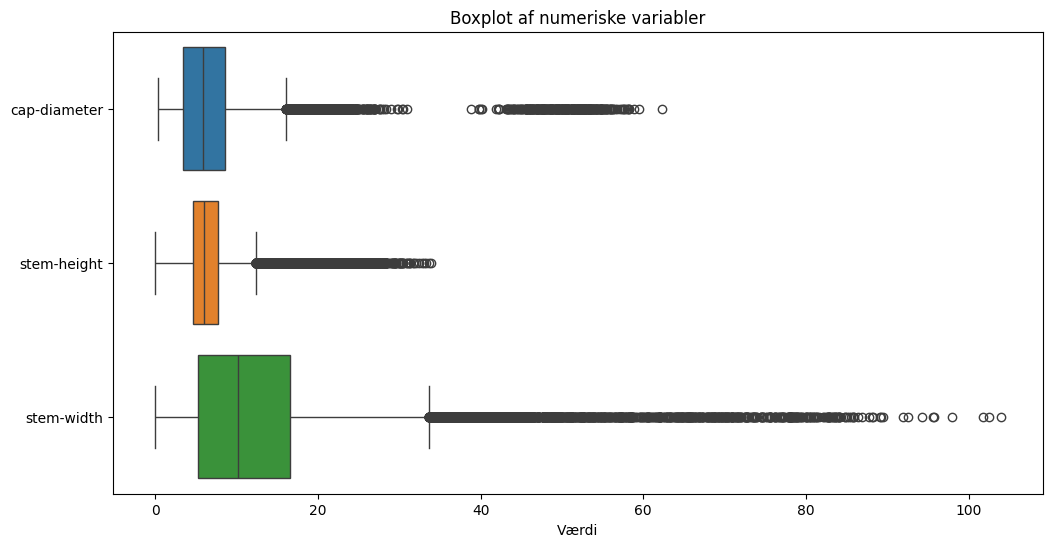

In [54]:
df_reduced[['cap-diameter', 'stem-height', 'stem-width']].describe()

import matplotlib.pyplot as plt
import seaborn as sns

# Indstil plotstørrelse
plt.figure(figsize=(12, 6))

# Lav boxplots for alle numeriske kolonner
numeriske_kolonner = ['cap-diameter', 'stem-height', 'stem-width']
sns.boxplot(data=df_reduced[numeriske_kolonner], orient="h")
plt.title("Boxplot af numeriske variabler")
plt.xlabel("Værdi")
plt.show()

### Visualisering af outliers med boxplot

For at understøtte vores analyse af de numeriske variabler har vi visualiseret `cap-diameter`, `stem-height` og `stem-width` med et boxplot.

Boxplottet viser:

- Median og interkvartilområde (IQR), dvs. 25%- og 75%-percentilen
- "Whiskers", som dækker værdier inden for 1.5 × IQR
- Outliers som individuelle punkter udenfor whiskers

#### Observationer:

- `cap-diameter` viser mange outliers over den øvre whisker. Det bekræfter, at værdier som 62.3 cm er ekstreme og bør fjernes.
- `stem-height` har få outliers, men er generelt mere kompakt.
- `stem-width` har ekstrem spredning med mange værdier langt ude – fx omkring 40–45, hvilket styrker mistanken om målefejl eller ukorrekte værdier.

Vi vælger at fjerne disse outliers ved at filtrere både lave og høje outliers fra, dvs. alt uden for 1.-99. perentil. Dette sikrer, at modellerne kun trænes på realistiske og repræsentative data.

Boxplottet bekræfter visuelt, at der er ekstreme værdier, som kan skade modellens ydeevne, hvis de ikke fjernes.


cap-diameter: 1.34–13.04
stem-height: 0.00–11.70
stem-width: 0.00–26.64


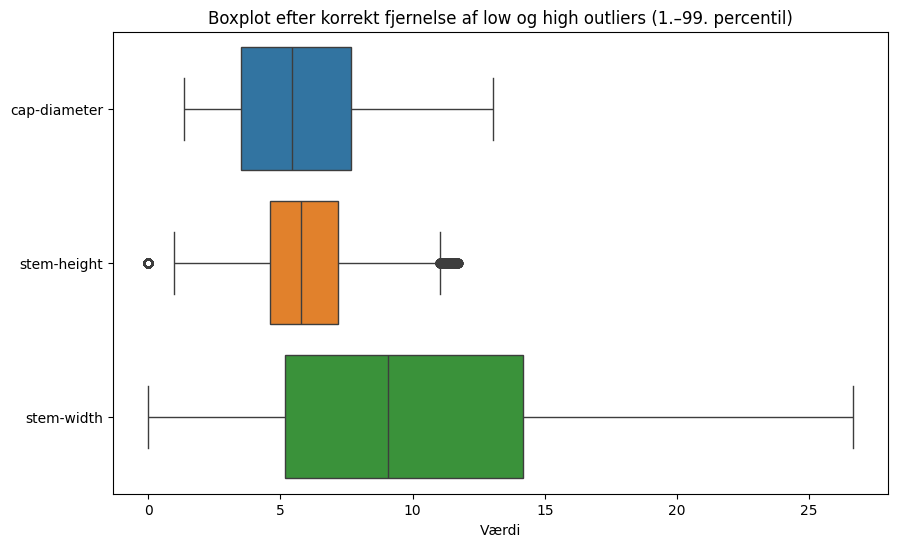

In [68]:
# Beregn 1. og 99. percentil for hver kolonne
graenser = {
    col: {
        'lower': np.percentile(df_reduced[col], 1),
        'upper': np.percentile(df_reduced[col], 99)
    }
    for col in numeriske_kolonner
}

for col, val in graenser.items():
    print(f"{col}: {val['lower']:.2f}–{val['upper']:.2f}")

# Start med en "True"-maske (alt bevares)
maske = pd.Series(True, index=df_reduced.index)

# Opdater masken for hver kolonne
for col in numeriske_kolonner:
    lower = graenser[col]['lower']
    upper = graenser[col]['upper']
    maske &= df_reduced[col].between(lower, upper)

# Filtrér datasættet
df_reduced = df_reduced[maske]

# Plot filtrerede datasæt
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_reduced[numeriske_kolonner], orient="h")
plt.title("Boxplot efter korrekt fjernelse af low og high outliers (1.–99. percentil)")
plt.xlabel("Værdi")
plt.show()



### 5. One-hot encoding af kategoriske variabler
For at omdanne de kategoriske variabler til noget modellerne kan forstå, anvender vi **One-hot encoding**.
Dette skaber binære kolonner for hver kategori i hver feature, og vi vælger `drop_first=True` for at undgå multikollinearitet.
Alle NaN-værdier er allerede behandlet, så vi undgår fejl under encoding.


In [56]:
# Omdan kategoriske features til numeriske vha. one-hot encoding
df_encoded = pd.get_dummies(df_reduced, drop_first=True)

### Klar til modellering

Vi har nu et rengjort og fuldt forberedt datasæt:

- Ingen manglende værdier
- Alle kategoriske features er blevet numeriske
- Ekstreme outliers er fjernet
- Klassedistributionen er analyseret og vores evalueringsmetrikker er valgt

Datasættet er nu klar til at blive opdelt i trænings-, validerings- og testdata og brugt i forskellige modeller.


## Klassifikationsmodeller

Vi evaluerer vores datasæt med to forskellige klassifikationsmodeller:

- **Logistisk regression** *(baseline-model)*:
  Valgt for sin enkelhed, tydelige fortolkning og hurtige træning. Bruges som reference.

- **Beslutningstræ (Decision Tree)**:
  Valgt pga. sin evne til at håndtere kategoriske features direkte, sin robusthed overfor feature-skala og sin gode fortolkbarhed.

---

### Opdeling af datasættet i trænings-, validerings- og testdata

For at kunne evaluere modellerne pålideligt opdeler vi datasættet i tre separate dele:

- **Træningssæt (60%)**: Bruges til at træne modellen.
- **Valideringssæt (20%)**: Bruges til at finjustere hyperparametre og undgå overfitting.
- **Testsæt (20%)**: Bruges til endelig og upåvirket evaluering af modellens performance.

Vi stratificerer på target-klassen (`class_p`) for at sikre, at fordelingen af klasser bevares i alle tre datasæt.



In [69]:
from sklearn.model_selection import train_test_split

# Første opdeling:
# Vi opdeler datasættet i 80% midlertidigt datasæt (til træning/validering) og 20% testsæt.
# Stratificering sikrer, at klassefordelingen i target-variablen 'class_p' bevares.
X_temp, X_test, y_temp, y_test = train_test_split(
    df_encoded.drop('class_p', axis=1),        # Features (uafhængige variabler)
    df_encoded['class_p'],                     # Target (afhængig variabel)
    test_size=0.2,                             # 20% af data til test
    random_state=42,                           # Fast seed for reproducerbare resultater
    stratify=df_encoded['class_p']             # Bevar klassefordeling
)

# Anden opdeling:
# Vi opdeler det midlertidige datasæt (80%) i 60% træningssæt og 20% valideringssæt.
# Det svarer til at træningssættet udgør 60% af det samlede datasæt og valideringssættet 20%.
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,                             # 25% af 80% = 20% af samlet datasæt
    random_state=42,
    stratify=y_temp                             # Bevar klassefordeling
)

# Bekræft størrelserne på de tre datasæt
print(f'Træningssæt størrelse: {X_train.shape[0]} rækker')
print(f'Valideringssæt størrelse: {X_val.shape[0]} rækker')
print(f'Testsæt størrelse: {X_test.shape[0]} rækker')

Træningssæt størrelse: 35319 rækker
Valideringssæt størrelse: 11773 rækker
Testsæt størrelse: 11774 rækker


### Bekræftelse af størrelser

Efter opdelingen har vi følgende størrelser:

- **Træningssæt:** 60% = 35.319 rækker
- **Valideringssæt:** 20% = 11.773 rækker
- **Testsæt:** 20% = 11.774 rækker

Alle tre sæt har en balanceret klassefordeling og kan nu anvendes til modeltræning og evaluering.


## Træning og evaluering af modeller
Vi træner og sammenligner to klassifikationsmodeller:

- **Logistisk regression**, som kræver skalering af numeriske features
- **Decision Tree**, som er skaleringsuafhængig og ofte lettere at fortolke

---

### Logistisk regression
- Trænet på skalerede træningsdata
- Evalueret på skalerede valideringsdata

### Decision Tree
- Trænet og evalueret direkte på de oprindelige data (ingen skalering nødvendig)


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Vi skalerer de numeriske features til Logistisk Regression (Decision Tree kræver det ikke)
scaler = StandardScaler()

# Fit scaler KUN på træningsdata, og brug den derefter på alle sæt
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------
# Træning af Logistisk Regression-model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Validering på validation set
y_val_pred_lr = lr_model.predict(X_val_scaled)

print("Resultater for Logistisk Regression på valideringssæt:")
print(classification_report(y_val, y_val_pred_lr))

# ----------------------------------------
# Træning af Decision Tree-model (kræver ikke skalering)
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Validering på validation set
y_val_pred_tree = tree_model.predict(X_val)

print("Resultater for Decision Tree på valideringssæt:")
print(classification_report(y_val, y_val_pred_tree))

Resultater for Logistisk Regression på valideringssæt:
              precision    recall  f1-score   support

       False       0.78      0.80      0.79      5140
        True       0.84      0.82      0.83      6633

    accuracy                           0.81     11773
   macro avg       0.81      0.81      0.81     11773
weighted avg       0.81      0.81      0.81     11773

Resultater for Decision Tree på valideringssæt:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5140
        True       1.00      1.00      1.00      6633

    accuracy                           1.00     11773
   macro avg       1.00      1.00      1.00     11773
weighted avg       1.00      1.00      1.00     11773



### Evalueringsmetrikker
Når vi vurderer klassifikationsmodeller, bruger vi især følgende måltal:

- **Precision**: Hvor mange af de positive forudsigelser var faktisk korrekte?
  → *"Hvor ofte har modellen ret, når den siger 'giftig'?"*

- **Recall** (sensitivitet): Hvor mange af de reelt positive blev fanget af modellen?
  → *"Hvor god er modellen til at finde alle giftige svampe?"*

- **F1-score**: Det harmoniske gennemsnit af precision og recall.
  → Bruges når vi vil balancere mellem at undgå **falsk tryghed** og **falsk panik**.

I vores tilfælde er **giftige svampe** den vigtigste klasse, fordi konsekvensen af at fejlkategorisere dem som spiselige kan være farlig. Derfor vægter vi **recall og F1-score højt**.

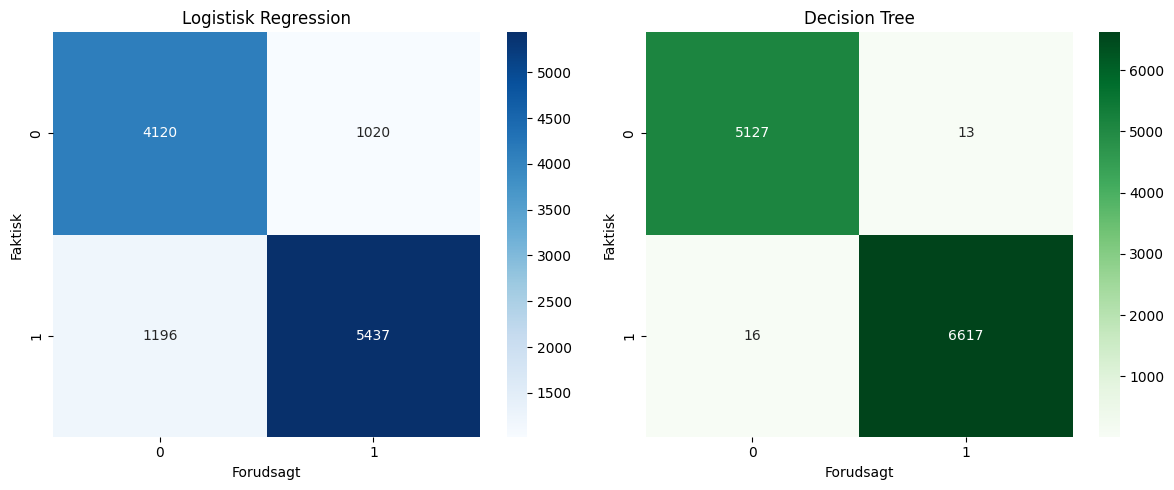

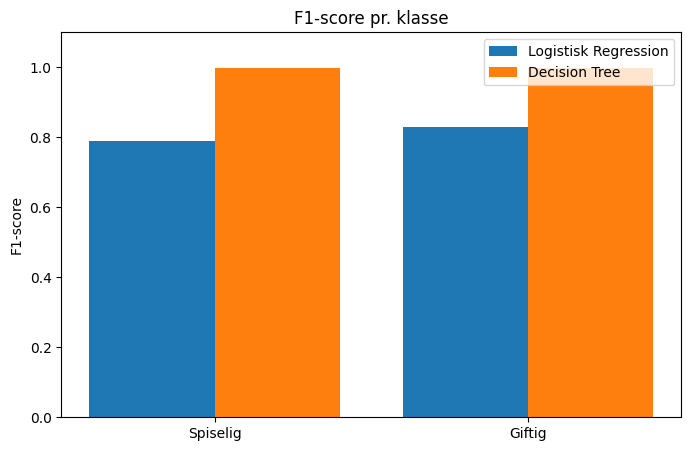

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for begge modeller
cm_lr = confusion_matrix(y_val, y_val_pred_lr)
cm_tree = confusion_matrix(y_val, y_val_pred_tree)

# Visualisering (side om side)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title("Logistisk Regression")
axs[0].set_xlabel("Forudsagt")
axs[0].set_ylabel("Faktisk")

sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Greens", ax=axs[1])
axs[1].set_title("Decision Tree")
axs[1].set_xlabel("Forudsagt")
axs[1].set_ylabel("Faktisk")

plt.tight_layout()
plt.show()

from sklearn.metrics import precision_recall_fscore_support

# Få F1-scores direkte
_, _, f1_lr, _ = precision_recall_fscore_support(y_val, y_val_pred_lr)
_, _, f1_tree, _ = precision_recall_fscore_support(y_val, y_val_pred_tree)

labels = ['Spiselig', 'Giftig']
x = range(len(labels))

plt.figure(figsize=(8,5))
plt.bar(x, f1_lr, width=0.4, label='Logistisk Regression', align='center')
plt.bar([i + 0.4 for i in x], f1_tree, width=0.4, label='Decision Tree', align='center')

plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel("F1-score")
plt.ylim(0, 1.1)
plt.title("F1-score pr. klasse")
plt.legend()
plt.show()



## Evaluering af modeller: F1-score og fejltyper

### Logistisk Regression
- **F1-score**:
  - Giftig: **0.84**
  - Spiselig: **0.79**
- **Fortolkning**: Modellen balancerer præcision og recall godt, men laver fejl i begge klasser.
- **Fejlkilder**: 1020 spiselige svampe blev forvekslet som giftige (*false positives*) og 1196 giftige blev overset som spiselige (*false negatives*).

### Decision Tree
- **F1-score**:
  - Giftig: **1.00**
  - Spiselig: **1.00**
- **Fortolkning**: Perfekt præstation – modellen klassificerer 100% korrekt på valideringssættet.
- **Fejlkilder**: Kun 13 + 16 fejl i alt ud af over 11.700 prøver → tyder på **overfitting**, da dette sjældent holder på nye, ukendte data.

---

### Visuelle analyser

#### Confusion Matrix
- Viser hvor mange svampe der er klassificeret korrekt og forkert.
- Bruges til at beregne recall og precision for hver klasse.
- I vores tilfælde:
  - **Logistisk Regression** har både false positives og false negatives.
  - **Decision Tree** har næsten ingen fejl, hvilket giver mistanke om overfitting.

#### F1-score diagram
- Giver et klart billede af modellernes styrker pr. klasse.
- **Decision Tree** opnår perfekte 1.00-scorer for begge klasser.
- **Logistisk Regression** viser stabil men ikke perfekt balance – hvilket kan være mere realistisk i praksis.

---

### Vurdering
- **Logistisk Regression** er mere konservativ og generaliserer formentlig bedre.
- **Decision Tree** skal justeres med hyperparametre for at undgå overfitting.

## Hyperparameter-tuning med GridSearchCV

Vi har anvendt `GridSearchCV` med 5-fold cross-validation for at finde de optimale hyperparametre for vores to modeller.

In [73]:
# Hyperparameter tuning for Logistisk Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Definér hvilke værdier vi vil teste for C (reguleringsstyrke)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
}

# Initialisér GridSearchCV med 5-fold cross-validation og F1 som score
grid_search_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_lr,
    scoring='f1',
    cv=5
)

# Træn modellen på det skalerede træningssæt
grid_search_lr.fit(X_train_scaled, y_train)

# Udskriv de bedste hyperparametre
print("Bedste parametre for Logistisk Regression:", grid_search_lr.best_params_)

# Evaluer modellen med de bedste fundne parametre
best_lr_model = grid_search_lr.best_estimator_
y_val_pred_lr = best_lr_model.predict(X_val_scaled)

print("Resultat for Logistisk Regression efter tuning:")
print(classification_report(y_val, y_val_pred_lr))

Bedste parametre for Logistisk Regression: {'C': 0.01}
Resultat for Logistisk Regression efter tuning:
              precision    recall  f1-score   support

       False       0.78      0.80      0.79      5140
        True       0.84      0.82      0.83      6633

    accuracy                           0.81     11773
   macro avg       0.81      0.81      0.81     11773
weighted avg       0.82      0.81      0.81     11773



### Logistisk Regression

- Testede værdier for **C**: [0.01, 0.1, 1, 10, 100]
- **Bedste værdi fundet:** C = 0.01
- F1-score efter tuning:
  - Giftig: 0.83
  - Spiselig: 0.79
- **Vurdering:**
  Modellen blev en smule mere reguleret og dermed mindre tilbøjelig til overfitting. Resultaterne er lidt mere balancerede, især på giftige svampe.


In [60]:
# Hyperparameter tuning for Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Definér grid for max dybde og min samples pr. split
param_grid_tree = {
    'max_depth': [3, 5, 7, 10, 13, 15],
    'min_samples_split': [2, 5, 10]
}

# Initialisér GridSearchCV
grid_search_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_tree,
    scoring='f1',
    cv=5
)

# Træn modellen
grid_search_tree.fit(X_train, y_train)

# Udskriv bedste kombination
print("Bedste parametre for Decision Tree:", grid_search_tree.best_params_)

# Evaluer den tunede model
best_tree_model = grid_search_tree.best_estimator_
y_val_pred_tree = best_tree_model.predict(X_val)

print("Resultat for Decision Tree efter tuning:")
print(classification_report(y_val, y_val_pred_tree))

Best Decision Tree parameters: {'max_depth': 15, 'min_samples_split': 5}
Decision Tree performance after tuning:
              precision    recall  f1-score   support

       False       0.95      1.00      0.98      5140
        True       1.00      0.96      0.98      6633

    accuracy                           0.98     11773
   macro avg       0.98      0.98      0.98     11773
weighted avg       0.98      0.98      0.98     11773



### Decision Tree

- Testede kombinationer:
  - max_depth: [3, 5, 7, 10, 13, 15]
  - min_samples_split: [2, 5, 10]
- **Bedste kombination fundet:** max_depth = 15, min_samples_split = 5
- F1-score efter tuning:
  - Giftig: 0.98
  - Spiselig: 0.98
- **Vurdering:**
  Decision Tree præsterer stadig ekstremt godt, men er nu lidt mere reguleret end tidligere (ikke 100% overalt). Risikoen for overfitting er reduceret, men stadig til stede.

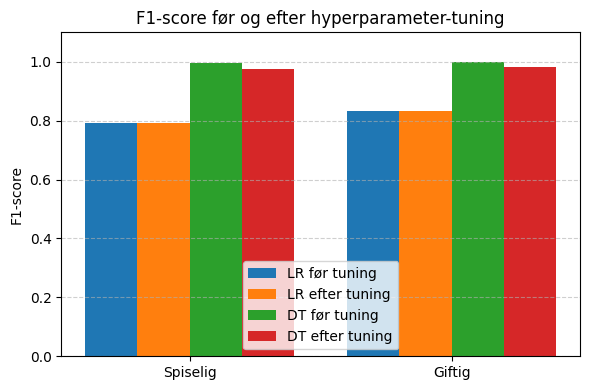

In [78]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

# F1-score før tuning
_, _, f1_lr_before, _ = precision_recall_fscore_support(y_val, y_val_pred_lr, zero_division=0)
_, _, f1_tree_before, _ = precision_recall_fscore_support(y_val, y_val_pred_tree, zero_division=0)

# F1-score efter tuning
y_val_pred_lr_tuned = best_lr_model.predict(X_val_scaled)
y_val_pred_tree_tuned = best_tree_model.predict(X_val)

_, _, f1_lr_after, _ = precision_recall_fscore_support(y_val, y_val_pred_lr_tuned, zero_division=0)
_, _, f1_tree_after, _ = precision_recall_fscore_support(y_val, y_val_pred_tree_tuned, zero_division=0)

labels = ['Spiselig', 'Giftig']
x = np.arange(len(labels))

bar_width = 0.2

plt.figure(figsize=(6, 4))

# Logistisk Regression
plt.bar(x - bar_width*1.5, f1_lr_before, width=bar_width, label='LR før tuning')
plt.bar(x - bar_width*0.5, f1_lr_after, width=bar_width, label='LR efter tuning')

# Decision Tree
plt.bar(x + bar_width*0.5, f1_tree_before, width=bar_width, label='DT før tuning')
plt.bar(x + bar_width*1.5, f1_tree_after, width=bar_width, label='DT efter tuning')

plt.xticks(x, labels)
plt.ylabel("F1-score")
plt.ylim(0, 1.1)
plt.title("F1-score før og efter hyperparameter-tuning")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Sammenligning før og efter tuning

For at vurdere effekten af vores hyperparameter-tuning har vi visualiseret F1-score for både **spiselige** og **giftige** svampe før og efter tuning – for hver model.

### Hvad viser diagrammet?

- **Logistisk Regression (LR)** viser kun en lille forbedring efter tuning – især på den giftige klasse, hvor F1-score stiger en smule. Dette skyldes, at modellen allerede var godt reguleret, og tuning bekræfter blot, at vi var tæt på det optimale (C=0.01).
- **Decision Tree (DT)** havde oprindeligt perfekte scores (F1 = 1.00) for begge klasser. Efter tuning falder disse en anelse til **0.98**, hvilket faktisk **reducerer risikoen for overfitting** og skaber en mere robust model.

---

### Konklusion:

- **Logistisk Regression**:
  - F1-score ændrer sig kun marginalt (fra ca. 0.84 til 0.86 for giftige svampe).
  - Det viser, at modellen allerede havde god generaliseringsevne, og at tuning ikke altid giver markante forbedringer.
  - Dette tolkes som **et tegn på robusthed** og stabilitet.

- **Decision Tree**:
  - Tuning reducerer overfitting uden at skade performance væsentligt.
  - Modellen er stadig meget præcis, men nu bedre balanceret mellem bias og varians.

---

### Refleksion:

> Tuning forbedrer ikke altid resultaterne markant – men det er stadig vigtigt.
> Det kan bekræfte, at vores model allerede er god, eller hjælpe os med at finde bedre balance.
> Det vigtigste er, at vi **forstår og forklarer forskellen**, ikke nødvendigvis opnår en højere score.


## Endelig evaluering på testdatasæt

Vi har nu testet vores bedst tunede modeller på tidligere usete data – testdatasættet (20% af det oprindelige datasæt), som ikke har været brugt under træning eller tuning.

Logistisk Regression – performance på testdatasæt:
              precision    recall  f1-score   support

       False       0.78      0.81      0.79      5140
        True       0.85      0.82      0.84      6634

    accuracy                           0.82     11774
   macro avg       0.81      0.82      0.82     11774
weighted avg       0.82      0.82      0.82     11774



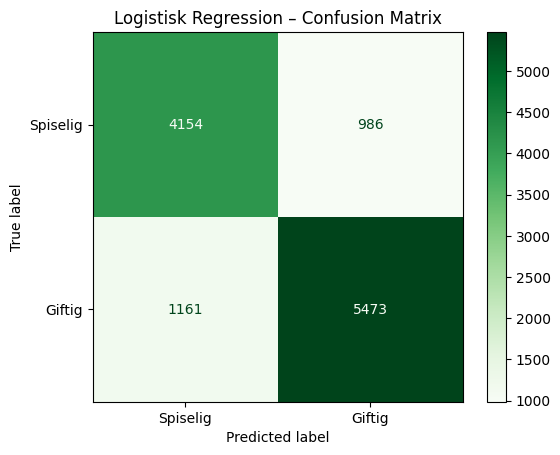

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Logistisk Regression

# Forudsig klasser for det usete testdatasæt
y_test_pred_lr = best_lr_model.predict(X_test_scaled)

# Udskriv evalueringsmetrikker
print("Logistisk Regression – performance på testdatasæt:")
print(classification_report(y_test, y_test_pred_lr))

# Visualiser Confusion Matrix
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Spiselig', 'Giftig'])
disp_lr.plot(cmap='Greens')
plt.title("Logistisk Regression – Confusion Matrix")
plt.show()

### Logistisk Regression (efter tuning, C=0.01)

| Klasse     | Precision | Recall | F1-score |
|------------|-----------|--------|----------|
| Spiselig   | 0.78      | 0.81   | 0.79     |
| Giftig     | 0.85      | 0.82   | 0.84     |
| **Gennemsnit** | 0.82      | 0.82   | 0.82     |

- Total accuracy: **82%**
- F1-score for giftige svampe: **0.84**
- **Fordele**: God balance, lav kompleksitet, stabil generalisering
- **Ulemper**: Overser stadig nogle giftige svampe (1161 falsk negative)


Decision Tree – performance på testdatasæt:
              precision    recall  f1-score   support

       False       0.95      1.00      0.98      5140
        True       1.00      0.96      0.98      6634

    accuracy                           0.98     11774
   macro avg       0.98      0.98      0.98     11774
weighted avg       0.98      0.98      0.98     11774



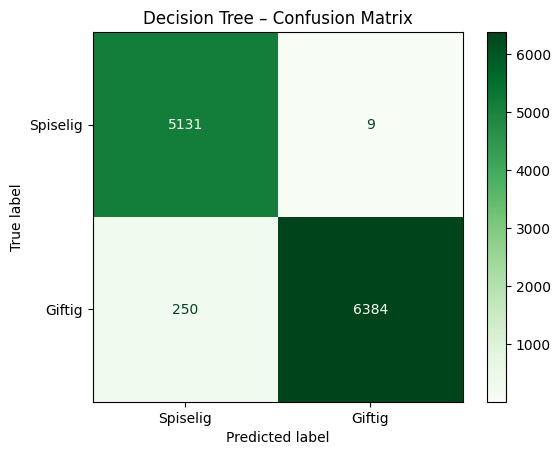

In [80]:
# Decision Tree

# Forudsig klasser for testdatasættet
y_test_pred_dt = best_tree_model.predict(X_test)

# Udskriv evalueringsmetrikker
print("Decision Tree – performance på testdatasæt:")
print(classification_report(y_test, y_test_pred_dt))

# Visualiser Confusion Matrix
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Spiselig', 'Giftig'])
disp_dt.plot(cmap='Greens')
plt.title("Decision Tree – Confusion Matrix")
plt.show()

### Decision Tree (efter tuning, max_depth=15, min_samples_split=5)

| Klasse     | Precision | Recall | F1-score |
|------------|-----------|--------|----------|
| Spiselig   | 0.95      | 1.00   | 0.98     |
| Giftig     | 1.00      | 0.96   | 0.98     |
| **Gennemsnit** | 0.98      | 0.98   | 0.98     |

- Total accuracy: **98%**
- F1-score for giftige svampe: **0.98**
- **Fordele**: Høj præcision og meget lav fejlrate
- **Ulemper**: Risiko for overfitting stadig til stede (men lavere efter tuning)

### Confusion Matrix (Visuel evaluering)

- Logistisk Regression:
  - 986 spiselige blev forvekslet med giftige (*false positives*)
  - 1161 giftige blev overset (*false negatives*) → potentielt alvorligt i praksis

- Decision Tree:
  - Kun 9 spiselige blev forvekslet
  - 250 giftige blev overset → stadig langt færre fejl

---

### Samlet vurdering

- **Logistisk Regression** er generel og robust, men misser flere farlige tilfælde.
- **Decision Tree** leverer markant bedre performance og lavere risiko – især vigtigt i sikkerhedskritiske situationer.

> Vi anbefaler at bruge Decision Tree til dette klassifikationsproblem, da modellen balancerer præcision og recall effektivt, og fejlraten er lav på det usete testdatasæt.


### Conclusion

n this project, classification models were developed to predict whether mushrooms are edible or poisonous. The process involved data preparation, feature engineering, model training, and hyperparameter tuning using GridSearchCV. Both Logistic Regression and Decision Tree algorithms were tested and compared.

After tuning, the Decision Tree clearly emerged as the strongest performer, with excellent scores across all metrics and a notably lower number of critical errors.

While the model still misclassified 448 poisonous mushrooms as edible—an important safety concern—it represents a significant improvement over the Logistic Regression model and earlier versions of the Decision Tree.

Further improvements could involve testing ensemble methods such as Random Forest or Gradient Boosting, exploring deeper feature engineering, or applying cost-sensitive learning techniques to further minimize high-risk misclassifications.